In [13]:
### Importing neccesary dependencies, labels has 0 and 1 output so a classifier is needed
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [14]:
### Importing database from postgresql
import pandas as pd 
import psycopg2 
import pandas.io.sql as sqlio 

connection = psycopg2.connect(user='postgres', password="password", 
host='127.0.0.1',
port='5432', 
database='Startup-Analysis')
sql = "SELECT * FROM startup_alldata"
data = sqlio.read_sql_query(sql,connection)

In [15]:
### Checking data head to see if everything is correct
data.head()

,state_code,year_,vp_gdp,labels,founded_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,...,has_angel,has_rounda,has_roundb,has_roundc,has_roundd,avg_participants,is_top500,reached_milestone,founded_first_funding_days_difference,first_last_funding_days_difference
0,CA,2007,1.9,1,2007,2.2493,3.0027,4.6685,6.7041,3,...,1,0,0,0,0,1.0000,0,1,821,275
1,CA,2000,7.7,1,2000,5.1260,9.9973,7.0055,7.0055,9,...,0,0,1,1,1,4.7500,1,1,1871,1778
2,CA,2009,3.2,1,2009,1.0329,1.0329,1.4575,2.2055,5,...,0,1,0,0,0,4.0000,1,1,377,0
3,CA,2002,1.8,1,2002,3.1315,5.3151,6.0027,6.0027,5,...,0,0,1,1,1,3.3333,1,1,1143,797
4,CA,2010,2.0,0,2010,0.0000,1.6685,0.0384,0.0384,2,...,1,0,0,0,0,1.0000,1,1,0,609


In [16]:
### Changing Nas with 9999 values, we already have 0 value in those columns so if we fill them with 0 we are creating data that might get the model 
## confused so we decided to move it up to a standard value so the data is not dropped and it doesn´t create wrong values
data["age_first_milestone_year"] = data["age_first_milestone_year"].fillna(value=9999)
data["age_last_milestone_year"] = data["age_last_milestone_year"].fillna(value=9999)

From here we separate our target and features, theres going to be different models trying to choose which one is the best for our question

In [17]:
## selecting  features and target, state code and founded at are dropped because they came from the second database and we don´t need it
X = data.drop(["labels", "state_code", "founded_at"], axis= 1)
y = data["labels"]

In [18]:
#### Create train and transform data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Data is going to be scale to avoid outliers noise 

In [19]:
### Scale the data 
scaler = StandardScaler()

# fit the data
X_scaler = scaler.fit(X_train)

# Transform data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [20]:
#Checking total number of values in train  
y_train.shape

(681,)

The first 2 models we thought where Logistic Regression and Random Forest Classifier, our data had a binary output so classification seemed correct, Logistic Regression was chosen and is the first model because is a more model centric approach, this means to get a better accuracy you need to change the model structure and not the data.

One thing to understand is that Logistic regression is not a 100% binary output, is more of a probability answer combined with a treshold, normally 0.5 and with this combination the labels are assigned. It is a low computer cost and with a fast speed so it´s a good model to see the data and look what you are facing, it is easy to understand.

Some of the disadvantages are that it assumes linearity between the predicted and the predictor variable, it can´t get complex relationships between variables, if the number of observations is less than the number of features it can´t be used.

Assumption
- Independence of errors
- Linearity 
- Absence of multicollinearity
- lack of strong influential outliers

In [107]:
### Create 2 models without PCA

#Start with logistic regression 
##create logistic regression 
model = LogisticRegression(penalty = 'l2',solver="liblinear", random_state=42 , C=1e42)

## fit data to model
model.fit(X_train_scaled, y_train)
## predict data
predictions = model.predict(X_test_scaled)

## print score over training to compare with test to see overfitting
print(model.score(X_train_scaled, y_train))


0.7929515418502202


In [108]:
# print Scores, confusion matrix and report
print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

0.7577092511013216
[[ 46  35]
 [ 20 126]]
              precision    recall  f1-score   support

           0       0.70      0.57      0.63        81
           1       0.78      0.86      0.82       146

    accuracy                           0.76       227
   macro avg       0.74      0.72      0.72       227
weighted avg       0.75      0.76      0.75       227



it wasn´t the best model, it had a low f1 score for 0, our focus is to predict failures as well as success so going to try random forest
Random Forest is a ensemble method, it´s created from decision trees that is why the name is forest, trees work in a yes no type of question, and they are easy to understand, although they are prone to overfiting so one way to avoid it is creating a random forest that uses the average answer to decide which is the answer.


This comes with advantages and disadvantages, like we said before it reduces overfiting because each tree is looking at different parts of the dataset, it is made from several weak learners, it has the ability to determine the importance from each variable.


Random forest can be considered a black box, so you really don´t know what is happening but you can change the "hyperparameters" to see different results, altough sklearn has a solution which is Grid Search but it takes a lot of computer power.


Assumptions
- Features should always have values so it can predict accurate results instead of an estimation 
- Trees must have low correlation
- Independence



In [23]:
### Creating random forest instance with 200 estimators and random state fixed so we can replicate it
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

## fitting the model
rf_model.fit(X_train_scaled, y_train)

## predicting the model and printing accuracy score for training to see overfitting
y_pred = rf_model.predict(X_test_scaled)

print(rf_model.score(X_train_scaled, y_train))

1.0


AUC del set de prueba 0.7140622357517336


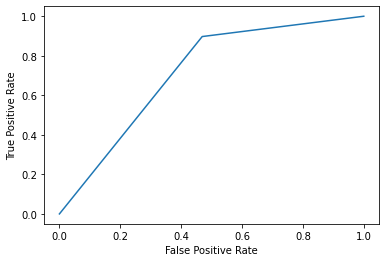

In [24]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
### We are implementing the Roc curve as an aposteriori metric to see the overall accuracy.
### Obtaining false positive rate and true positive rate from our y predictions and the real data (y_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
## plotting the roc curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
### printing accuracy
print("AUC del set de prueba",  auc(fpr, tpr))

In [25]:
### printing different metrics to see model development 
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))


0.7665198237885462
[[ 43  38]
 [ 15 131]]
              precision    recall  f1-score   support

           0       0.74      0.53      0.62        81
           1       0.78      0.90      0.83       146

    accuracy                           0.77       227
   macro avg       0.76      0.71      0.73       227
weighted avg       0.76      0.77      0.76       227



Our model had a score of 1 training and .76 for testing, this is clearly an overfited model, it has good precision for 0 and 1, better than before
and but the recall got worst for 0 and stayed the same for 1, it is a better model than logistic but from this model we are going to take the feature importance to see if we select less features we can get a better model

In [26]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.12297288517477217, 'relationships'),
 (0.10227241109357213, 'funding_total_usd'),
 (0.10120342094783054, 'age_last_milestone_year'),
 (0.07183039700003262, 'age_first_milestone_year'),
 (0.0603957411202714, 'age_last_funding_year'),
 (0.05626246069930827, 'age_first_funding_year'),
 (0.05416847915872194, 'founded_first_funding_days_difference'),
 (0.04786500853156586, 'avg_participants'),
 (0.0477223546896452, 'first_last_funding_days_difference'),
 (0.0456191808549948, 'vp_gdp'),
 (0.04433918173245761, 'year_'),
 (0.04083659235308208, 'milestones'),
 (0.030699302416839533, 'funding_rounds'),
 (0.021864052217146324, 'reached_milestone'),
 (0.01899666479969475, 'is_top500'),
 (0.011952149319711235, 'has_vc'),
 (0.011145801159194701, 'is_othercategory'),
 (0.010917004128105002, 'has_roundc'),
 (0.010087491604526213, 'is_otherstate'),
 (0.009037743045558754, 'has_rounda'),
 (0.0088267558639232, 'is_software'),
 (0.008437986899462653, 'has_roundb'),
 (0.008372477921728629, 'is_ca'),
 (

After looking at the first RF model we saw the importance of each feature and we decided to select the most important features and check for improvements

In [27]:
### Dropping least important features
data2 = data.drop(["is_consulting", "is_ecommerce", "is_advertising", 
"is_enterprise","is_biotech","is_ny", "is_tx", "state_code", "founded_at", "is_ma", 
"is_web", "is_mobile", "is_othercategory"], axis=1)

In [28]:
### Selecting most important features
X2 = data2[["age_last_milestone_year", "relationships", "funding_total_usd", "age_first_milestone_year",
 "age_last_funding_year", "age_first_funding_year", "founded_first_funding_days_difference",
  "first_last_funding_days_difference" ,"avg_participants", "year_", "vp_gdp","milestones","is_top500"]]
y2 = data2["labels"]

In [29]:
### Creating split for training and testing
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42, stratify=y)

In [30]:
### Creating standard scaler
scaler2 = StandardScaler()
## fitting our standard scaler so it knows the mean and sd
x_scaler2 = scaler2.fit(X_train2)
### transforming training data
X_train_scaled2 = x_scaler2.transform(X_train2)
### transforming test data
X_test_scaled2 = x_scaler2.transform(X_test2)

In [31]:
### Creating second Random forest classifier model
rf_model2 = RandomForestClassifier(n_estimators=200, random_state=42)
### fitting data
rf_model2.fit(X_train_scaled2, y_train)
## predicting data
y_pred2 = rf_model2.predict(X_test_scaled2)

In [32]:
print(accuracy_score(y_test2,y_pred2))
print(confusion_matrix(y_test2,y_pred2))
print(classification_report(y_test2, y_pred2))

0.6167400881057269
[[  8  70]
 [ 17 132]]
              precision    recall  f1-score   support

           0       0.32      0.10      0.16        78
           1       0.65      0.89      0.75       149

    accuracy                           0.62       227
   macro avg       0.49      0.49      0.45       227
weighted avg       0.54      0.62      0.55       227



As we can see this was not the answer, it got worse score overall, detecting failure startup is a toin coss so it´s not helpfull at all

AUC del set de prueba 0.4942350714162794


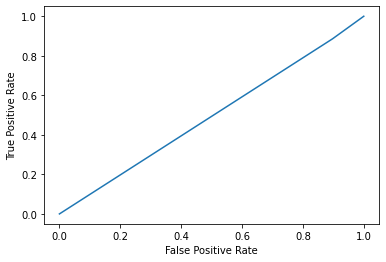

In [33]:
#### Roc curve to see accuracy 
fpr, tpr, _ = roc_curve(y_test2, y_pred2)
### plot roc curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print("AUC del set de prueba",  auc(fpr, tpr))

The roc curve is a straight line, this is the worst score we could have, so we are ignoring this model

It might be bad with a random forest because we have less features but we might get a higher score with a logistic regression

In [34]:
### Creating model instance
log_reg = LogisticRegression(random_state=42)
## fitting the model
log_reg.fit(X_train_scaled2, y_train2)
##predicting data
pred2 = log_reg.predict(X_test_scaled2)


In [35]:
#### printing model score on training data
print(log_reg.score(X_train_scaled2, y_train2))
print(accuracy_score(y_test2,pred2))
print(classification_report(y_test2,pred2))

0.7591776798825257
0.7312775330396476
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        78
           1       0.77      0.85      0.81       149

    accuracy                           0.73       227
   macro avg       0.70      0.68      0.68       227
weighted avg       0.72      0.73      0.72       227



It got a 75% accuracy for training data and 73% for testing data, is not overfited, for the precision, it did a little bit better than a random event but the recall for 0 is to low, not considering this model 

We are going to try to create a principal components analysis(PCA) to reduce the number of features, PCA is used to reduce the number of predictor variables, the advantages are that it removes correlated features, it improves visualization and it´s easier for the machine to run the algorithm, disadvantage are it becomes less clear and more difficult to interpret, it needs to have standardization and you loose some of the information

In [36]:
### pca, the 0.95 defines the treshold for components where the 95% of the variance is explained
pca2 = PCA(0.95)
pca2.fit(X_train_scaled2)
pca2.n_components_

8

With 8 PCA we can try and see if the model gets a better result, this is for the data with less features

In [42]:
## Starting PCA instance
pca = PCA(n_components= 8)
## fitting PCA with data
pca.fit(X_train_scaled2)
#Transform train data with PCA
X_train_scaled_pca = pca.transform(X_train_scaled2)
## Transform test data with PCA
X_test_scaled_pca = pca.transform(X_test_scaled2)

In [43]:
### Creating Random forest instance
rf = RandomForestClassifier(n_estimators=500)
## training model 
rf.fit(X_train_scaled_pca, y_train2)
## Predicting outcomes
y_pred= rf.predict(X_test_scaled_pca)

In [44]:
### Printing metrics to evaluate model
print(accuracy_score(y_test2,y_pred))
print(confusion_matrix(y_test2,y_pred))
print(classification_report(y_test2, y_pred))


0.7180616740088106
[[ 40  38]
 [ 26 123]]
              precision    recall  f1-score   support

           0       0.61      0.51      0.56        78
           1       0.76      0.83      0.79       149

    accuracy                           0.72       227
   macro avg       0.69      0.67      0.67       227
weighted avg       0.71      0.72      0.71       227



In [45]:
### pca, 25 components explain the 95 variance between the dataset
pca = PCA(0.95)
### fitting X to PCA
pca.fit(X_train_scaled)
## Looking at the number of components that explain 95% of the variance
pca.n_components_

25

In [46]:
## Creating PCA instance with the 95% percent variance from before
pca = PCA(n_components= 25)
### Fitting the dataset with all the features to a pca
pca.fit(X_train_scaled)
### Transforming train data
X_train_scaled_pca = pca.transform(X_train_scaled)
### Transforming test data
X_test_scaled_pca = pca.transform(X_test_scaled)

In [47]:
### Creating Random Forest instance
rf = RandomForestClassifier(n_estimators=500)
## Training the model
rf.fit(X_train_scaled_pca, y_train)
## Predicting
y_pred= rf.predict(X_test_scaled_pca)

In [48]:
# Printing metrics 
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))


0.7312775330396476
[[ 41  40]
 [ 21 125]]
              precision    recall  f1-score   support

           0       0.66      0.51      0.57        81
           1       0.76      0.86      0.80       146

    accuracy                           0.73       227
   macro avg       0.71      0.68      0.69       227
weighted avg       0.72      0.73      0.72       227



In [49]:
#Logistic Regression
log_model = LogisticRegression(random_state=42)

In [50]:
## Training model
log_model.fit(X_train_scaled_pca, y_train)
# Predicting
predictions = log_model.predict(X_test_scaled_pca)

In [52]:
# Printing metrics
print(accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))


0.7400881057268722
[[ 42  39]
 [ 20 126]]
              precision    recall  f1-score   support

           0       0.68      0.52      0.59        81
           1       0.76      0.86      0.81       146

    accuracy                           0.74       227
   macro avg       0.72      0.69      0.70       227
weighted avg       0.73      0.74      0.73       227



We didn´t get any better accuracy so we are going to step it up a little bit creating a neural network and look at the results, the activation functions were selected for what we need and at the end we needed a sigmoid activation to get a binary classifier

In [53]:
#Importing dependencies
import tensorflow as tf

In [54]:
## Creating model instance
nn_model = tf.keras.models.Sequential()

In [59]:
## Adding layers to our model 
nn_model.add(tf.keras.layers.Dense(units=80, activation="relu", input_dim=36))
nn_model.add(tf.keras.layers.Dense(units=50, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=30, activation="tanh"))
nn_model.add(tf.keras.layers.Dense(units=20, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [60]:
# Compiling model to set loss and optimizer
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
## fit the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=500)

Epoch 1/500
22/22 [==============================] - 3s 1ms/step - loss: 0.6658 - accuracy: 0.6358
Epoch 2/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6067 - accuracy: 0.6623
Epoch 3/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5683 - accuracy: 0.6623
Epoch 4/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5352 - accuracy: 0.7239
Epoch 5/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4994 - accuracy: 0.7856
Epoch 6/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4489 - accuracy: 0.8179
Epoch 7/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4021 - accuracy: 0.8429
Epoch 8/500
22/22 [==============================] - 0s 2ms/step - loss: 0.3896 - accuracy: 0.8502
Epoch 9/500
22/22 [==============================] - 0s 2ms/step - loss: 0.3349 - accuracy: 0.8737
Epoch 10/500
22/22 [==============================] - 0s 2ms/step - loss: 0.2963 - accuracy: 0.8957
Epoch 11/

In [61]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 1.6769 - accuracy: 0.7093 - 244ms/epoch - 31ms/step
Loss: 1.6769009828567505, Accuracy: 0.7092511057853699


got a 70% accuracy, maybe adding some layers or changing activation functions we can get a better result

In [62]:
## Creating second model instance
nn_model2 = tf.keras.models.Sequential()

In [63]:
## Adding layers
nn_model2.add(tf.keras.layers.Dense(units=80, activation="relu", input_dim=36))
nn_model2.add(tf.keras.layers.Dense(units=50, activation="relu"))
nn_model2.add(tf.keras.layers.Dense(units=30, activation="hard_sigmoid"))
nn_model2.add(tf.keras.layers.Dense(units=25, activation="tanh"))
nn_model2.add(tf.keras.layers.Dense(units=20, activation="tanh"))
nn_model2.add(tf.keras.layers.Dense(units=10, activation="relu"))
nn_model2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [66]:
## Compiling model
nn_model2.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
#fitting model
fit_model = nn_model2.fit(X_train_scaled, y_train, epochs=500)

Epoch 1/500
22/22 [==============================] - 2s 2ms/step - loss: 8.8892e-05 - accuracy: 1.0000
Epoch 2/500
22/22 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9956
Epoch 3/500
22/22 [==============================] - 0s 3ms/step - loss: 0.0433 - accuracy: 0.9927
Epoch 4/500
22/22 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9985
Epoch 5/500
22/22 [==============================] - 0s 3ms/step - loss: 0.0053 - accuracy: 0.9985
Epoch 6/500
22/22 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9912
Epoch 7/500
22/22 [==============================] - 0s 2ms/step - loss: 0.0476 - accuracy: 0.9912
Epoch 8/500
22/22 [==============================] - 0s 2ms/step - loss: 0.0895 - accuracy: 0.9897
Epoch 9/500
22/22 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.9941
Epoch 10/500
22/22 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 0.9985
Epoch

In [67]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 3.8813 - accuracy: 0.7181 - 208ms/epoch - 26ms/step
Loss: 3.881349802017212, Accuracy: 0.7180616855621338


In [68]:
## Creating third model instance
nn_model3 = tf.keras.models.Sequential()

In [69]:
### Adding layers
nn_model3.add(tf.keras.layers.Dense(units=80, activation="relu", input_dim=36))
nn_model3.add(tf.keras.layers.Dense(units=50, activation="relu"))
nn_model3.add(tf.keras.layers.Dense(units=30, activation="hard_sigmoid"))
nn_model3.add(tf.keras.layers.Dense(units=20, activation="tanh"))
nn_model3.add(tf.keras.layers.Dense(units=10, activation="relu"))
nn_model3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [70]:
### Compiling model
nn_model3.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
## fitting model
fit_model = nn_model3.fit(X_train_scaled, y_train, epochs=500)

Epoch 1/500
22/22 [==============================] - 1s 1ms/step - loss: 0.6496 - accuracy: 0.6358
Epoch 2/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6053 - accuracy: 0.6711
Epoch 3/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5494 - accuracy: 0.7504
Epoch 4/500
22/22 [==============================] - 0s 1ms/step - loss: 0.4951 - accuracy: 0.7753
Epoch 5/500
22/22 [==============================] - 0s 1ms/step - loss: 0.4703 - accuracy: 0.7930
Epoch 6/500
22/22 [==============================] - 0s 1ms/step - loss: 0.4530 - accuracy: 0.8106
Epoch 7/500
22/22 [==============================] - 0s 1ms/step - loss: 0.4380 - accuracy: 0.8179
Epoch 8/500
22/22 [==============================] - 0s 1ms/step - loss: 0.4233 - accuracy: 0.8282
Epoch 9/500
22/22 [==============================] - 0s 1ms/step - loss: 0.4111 - accuracy: 0.8399
Epoch 10/500
22/22 [==============================] - 0s 1ms/step - loss: 0.3938 - accuracy: 0.8473
Epoch 11/

In [71]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 4.4652 - accuracy: 0.7181 - 152ms/epoch - 19ms/step
Loss: 4.465232849121094, Accuracy: 0.7180616855621338


In [72]:
## Creating fourth model instance
nn_model4 = tf.keras.models.Sequential()

In [73]:
## Adding layers
nn_model4.add(tf.keras.layers.Dense(units=80, activation="relu", input_dim=36))
nn_model4.add(tf.keras.layers.Dense(units=50, activation="relu"))
nn_model4.add(tf.keras.layers.Dense(units=40, activation="hard_sigmoid"))
nn_model4.add(tf.keras.layers.Dense(units=15, activation="tanh"))
nn_model4.add(tf.keras.layers.Dense(units=5, activation="relu"))
nn_model4.add(tf.keras.layers.Dense(units=2, activation="tanh"))
nn_model4.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [74]:
## Compiling model
nn_model4.compile(loss="BinaryCrossentropy", optimizer="adam", metrics=["accuracy"])
## fitting model
fit_model = nn_model4.fit(X_train_scaled, y_train, epochs=500)

Epoch 1/500
22/22 [==============================] - 1s 2ms/step - loss: 0.6881 - accuracy: 0.5859
Epoch 2/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6596 - accuracy: 0.6623
Epoch 3/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6384 - accuracy: 0.6623
Epoch 4/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6050 - accuracy: 0.6623
Epoch 5/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5394 - accuracy: 0.7606
Epoch 6/500
22/22 [==============================] - 0s 2ms/step - loss: 0.5082 - accuracy: 0.7988
Epoch 7/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.8032
Epoch 8/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4670 - accuracy: 0.8135
Epoch 9/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4505 - accuracy: 0.8209
Epoch 10/500
22/22 [==============================] - 0s 2ms/step - loss: 0.4363 - accuracy: 0.8370
Epoch 11/

In [49]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model4.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 1.3151 - accuracy: 0.6960 - 206ms/epoch - 26ms/step
Loss: 1.3151037693023682, Accuracy: 0.6960352659225464


The first random forest looks like the best option, the NN is overffiting so we are not going to use it like that, looking at the labels it 
appears to need a undersampling metodology so we are going to use a Random Undersampling, Random Oversampling and SMOTEEN to see if any of this help

In [165]:
## Importing dependencies 
from imblearn.under_sampling import RandomUnderSampler
## Creating Random undersampler 
ros = RandomUnderSampler(random_state=42)
### Transform the data to undersampling
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

In [169]:
## initializing random forest
rf_ = RandomForestClassifier(n_estimators= 1000, max_depth= 15, 
min_samples_split = 0.34253241,   min_samples_leaf= 0.041234523, class_weight = {0:1,1:1}, random_state=0)

In [170]:
## fitting and predicting
rf_.fit(X_resampled, y_resampled)
y_pred = rf_.predict(X_test_scaled)

In [171]:
### looking accuracy
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

"""got worse precission but better recall, f1-score worse so this is not the solution"""

0.7180616740088106
[[ 55  26]
 [ 38 108]]
              precision    recall  f1-score   support

           0       0.59      0.68      0.63        81
           1       0.81      0.74      0.77       146

    accuracy                           0.72       227
   macro avg       0.70      0.71      0.70       227
weighted avg       0.73      0.72      0.72       227



'got worse precission but better recall, f1-score worse so this is not the solution'

In [192]:
### Creating logistic regression instance
log_r = LogisticRegression(random_state=42, class_weight= {0:0.798, 1:1})
## Fitting and training data 
log_r.fit(X_resampled, y_resampled)
y_pred = rf_.predict(X_test_scaled)

In [193]:
### looking accuracy
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

0.7180616740088106
[[ 55  26]
 [ 38 108]]
              precision    recall  f1-score   support

           0       0.59      0.68      0.63        81
           1       0.81      0.74      0.77       146

    accuracy                           0.72       227
   macro avg       0.70      0.71      0.70       227
weighted avg       0.73      0.72      0.72       227



In [194]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.combine import SMOTEENN

In [195]:
## create SMOTEEN function

def rf_model(X,y,model):

    model = model(n_estimators=200, random_state=42)
    ### create split data
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    smote = SMOTEENN(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
    model.fit(X_resampled, y_resampled)
    predictions = model.predict(X_test)
    report= classification_report_imbalanced(y_test,predictions)
    accuracy = accuracy_score(y_test,predictions)
    return print(report), print(f'the accuracy for {model} is {accuracy}')

In [196]:

rf_model(X,y, RandomForestClassifier)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.54      0.52      0.82      0.53      0.65      0.41        66
          1       0.80      0.82      0.52      0.81      0.65      0.44       161

avg / total       0.73      0.73      0.60      0.73      0.65      0.43       227

the accuracy for RandomForestClassifier(n_estimators=200, random_state=42) is 0.7312775330396476


(None, None)

In [197]:
rf_model(X,y,EasyEnsembleClassifier)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.67      0.47      0.88      0.55      0.65      0.40        76
          1       0.77      0.88      0.47      0.82      0.65      0.43       151

avg / total       0.73      0.74      0.61      0.73      0.65      0.42       227

the accuracy for EasyEnsembleClassifier(n_estimators=200, random_state=42) is 0.7444933920704846


(None, None)

In [198]:
rf_model(X,y, BalancedRandomForestClassifier)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.56      0.89      0.63      0.71      0.48        77
          1       0.80      0.89      0.56      0.84      0.71      0.52       150

avg / total       0.77      0.78      0.67      0.77      0.71      0.50       227

the accuracy for BalancedRandomForestClassifier(n_estimators=200, random_state=42) is 0.7797356828193832


(None, None)

In [128]:
rf_model(X,y, RandomForestClassifier)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.58      0.65      0.76      0.61      0.71      0.49        75
          1       0.82      0.76      0.65      0.79      0.71      0.50       152

avg / total       0.74      0.73      0.69      0.73      0.71      0.50       227

the accuracy for RandomForestClassifier(n_estimators=200, random_state=42) is 0.7268722466960352


(None, None)

In [262]:
from sklearn.model_selection import cross_val_score
rf_model(X, y, RandomForestClassifier)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.57      0.61      0.85      0.59      0.72      0.50        56
          1       0.87      0.85      0.61      0.86      0.72      0.53       171

avg / total       0.79      0.79      0.67      0.79      0.72      0.52       227

the accuracy for RandomForestClassifier(n_estimators=200) is 0.788546255506608


(None, None)

For this part we went to R and created a linear model to see which variables where significant (p<0.05) and decided to stay with them

In [132]:
data3 = data[["labels","first_last_funding_days_difference", "reached_milestone","is_top500", "has_roundb", "milestones", "funding_rounds", "relationships"]]

In [133]:
data3

,labels,first_last_funding_days_difference,reached_milestone,is_top500,has_roundb,milestones,funding_rounds,relationships
0,1,275,1,0,0,3,3,3
1,1,1778,1,1,1,1,4,9
2,1,0,1,1,0,2,1,5
3,1,797,1,1,1,1,3,5
4,0,609,1,1,0,1,2,2
...,...,...,...,...,...,...,...,...
903,1,1142,1,1,0,2,5,9
904,1,0,1,1,0,2,1,9
905,0,0,1,1,0,1,1,5
906,1,757,1,1,1,2,2,12


In [134]:
X3 = data3.drop("labels", axis=1)
y3 = data3["labels"]

In [135]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3)

In [136]:
st_scaler = StandardScaler()
X3_scaler = st_scaler.fit(X3_train)
X3_train_scaled = X3_scaler.transform(X3_train)
X3_test_scaled = X3_scaler.transform(X3_test)

In [137]:
lg_reg = LogisticRegression()
lg_reg.fit(X3_train_scaled, y3_train)
pred3 = lg_reg.predict(X3_test_scaled)

In [138]:
accuracy_score(y3_test,pred3)

0.7224669603524229

In [139]:
Rf = RandomForestClassifier(n_estimators=200)
Rf.fit(X3_train_scaled, y3_train)
y_pred3 = Rf.predict(X3_test_scaled)
accuracy_score(y3_test,y_pred3)

0.6960352422907489

AUC del set de prueba 0.6455823293172691


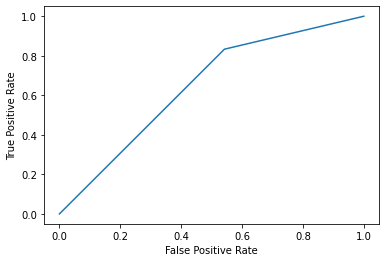

In [140]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
fpr, tpr, _ = roc_curve(y3_test, y_pred3)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

fpr, tpr, thresholds = roc_curve(y3_test,y_pred3, pos_label=1)
print("AUC del set de prueba",  auc(fpr, tpr))

In [147]:
X2 = data2.drop("labels", axis=1)
y2 = data2["labels"]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)

In [148]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf. fit(X2_train, y2_train)
pred2 = clf.predict(X2_test)
accuracy_score(y2_test, pred2)
print(classification_report(y2_test,pred2))

              precision    recall  f1-score   support

           0       0.85      0.56      0.67        70
           1       0.83      0.96      0.89       157

    accuracy                           0.83       227
   macro avg       0.84      0.76      0.78       227
weighted avg       0.83      0.83      0.82       227



In [95]:
from sklearn.ensemble import GradientBoostingClassifier
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
   classifier = GradientBoostingClassifier(n_estimators=20,
   learning_rate=learning_rate,
   max_features=5,
   max_depth=3,
   random_state=0)
   classifier.fit(X_train_scaled, y_train)
   

In [96]:
print(X2_test.shape)
print(y2_train.shape)

(227, 25)
(681,)


In [217]:
rf_2 = RandomForestClassifier(n_estimators=1500, max_depth=8, min_samples_leaf=3, class_weight = {0:0.86,1:0.42},random_state=0)
rf_2.fit(X_train_scaled, y_train)
pred = rf_2.predict(X_test_scaled)
print(classification_report(y_test,pred))
print(accuracy_score(y_test,pred))
print(confusion_matrix(y_test,pred))


              precision    recall  f1-score   support

           0       0.69      0.62      0.65        81
           1       0.80      0.85      0.82       146

    accuracy                           0.77       227
   macro avg       0.75      0.73      0.74       227
weighted avg       0.76      0.77      0.76       227

0.7665198237885462
[[ 50  31]
 [ 22 124]]


In [150]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

In [151]:
rf_3 = RandomForestClassifier(n_estimators=200)
weights = np.linspace(0.0,0.99,200)

# set the weights
param_grid= {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

## fitting in grid search 
Gridsearch = GridSearchCV(estimator= rf_3,
                            param_grid= param_grid,
                            cv=StratifiedKFold(),
                            scoring='accuracy').fit(X_train_scaled, y_train)

In [152]:
Gridsearch

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_estimators=200),
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115577889,
                                           1: 0.9850753768844221},
                                          {0: 0.019899497487437186,
                                           1: 0.980100502512562...
                                           1: 0.8905527638190954},
                                          {0: 0.11442211055276383,
                                           1: 0.8855778894472361},
                                          {0: 0.1193969

c:\Users\OMEN\anaconda3\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='weight', ylabel='score'>

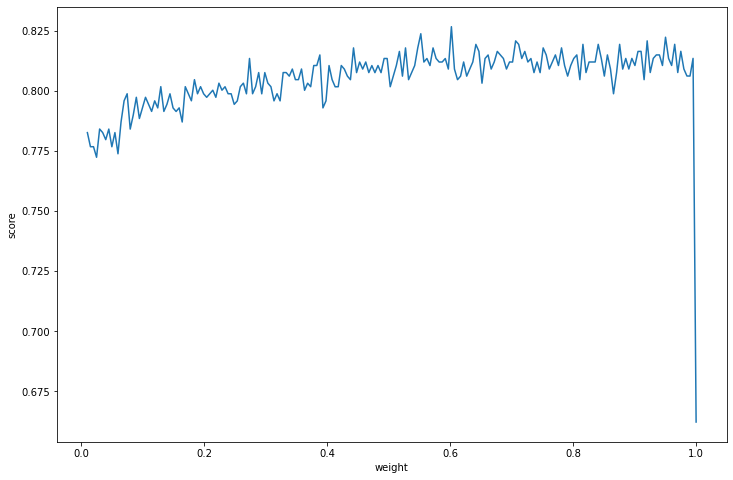

In [153]:
import seaborn as sns
plt.figure(figsize= (12,8))
weigh_data = pd.DataFrame({'score': Gridsearch.cv_results_['mean_test_score'], 'weight': (1-weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])


c:\Users\OMEN\anaconda3\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='weight', ylabel='score'>

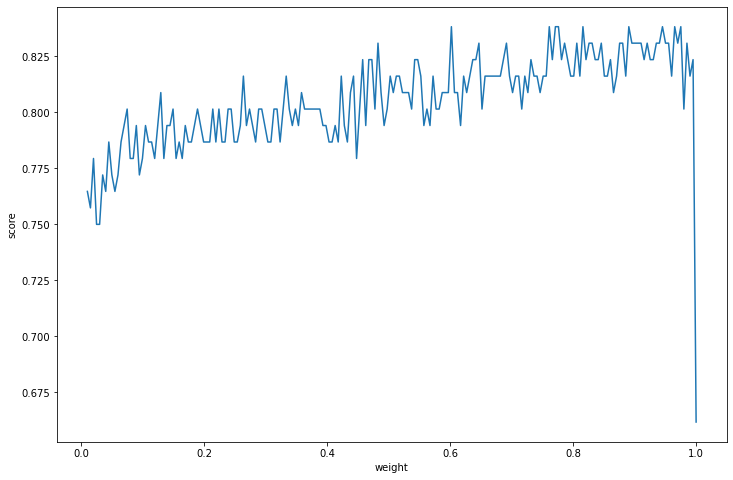

In [155]:
import seaborn as sns
plt.figure(figsize= (12,8))
weigh_data = pd.DataFrame({'score': Gridsearch.cv_results_['split1_test_score'], 'weight': (1-weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])


c:\Users\OMEN\anaconda3\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='weight', ylabel='score'>

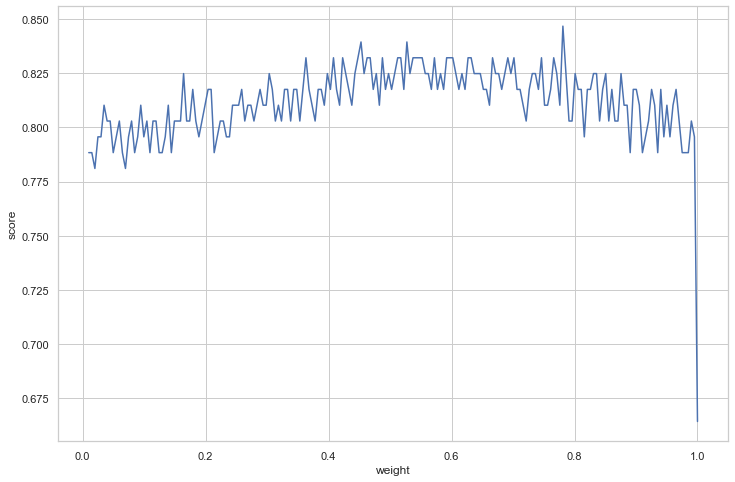

In [103]:
plt.figure(figsize= (12,8))
weigh_data = pd.DataFrame({'score': Gridsearch.cv_results_['split0_test_score'], 'weight': (1-weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])


In [163]:
rf_mod = RandomForestClassifier(n_estimators=200, class_weight = {0:0.79, 1:0.9}, random_state=42)
rf_mod.fit(X_train_scaled, y_train)
y_pred = rf_mod.predict(X_test_scaled)
print(rf_mod.score(X_train_scaled, y_train))
print(accuracy_score( y_test, y_pred))
print(classification_report(y_test, y_pred))

1.0
0.775330396475771
              precision    recall  f1-score   support

           0       0.76      0.54      0.63        81
           1       0.78      0.90      0.84       146

    accuracy                           0.78       227
   macro avg       0.77      0.72      0.74       227
weighted avg       0.77      0.78      0.76       227



In [104]:
from sklearn.ensemble import GradientBoostingClassifier

In [105]:
classifier = GradientBoostingClassifier(n_estimators=200,
   learning_rate=0.05,
   max_features=8,
   max_depth=3,
   random_state=0)

In [106]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

# A sample parameter

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1)


In [107]:
clf.fit(X_train_scaled, y_train)
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(clf.cv_results_)
#here Possible inputs for cross validation is cv=2, there two split split0 and split1
df[['split0_test_accuracy','split1_test_accuracy','split0_test_precision','split1_test_precision','split0_test_recall','split1_test_recall']]

,split0_test_accuracy,split1_test_accuracy,split0_test_precision,split1_test_precision,split0_test_recall,split1_test_recall
0,0.662757,0.661765,0.662757,0.661765,1.0,1.0
1,0.662757,0.661765,0.662757,0.661765,1.0,1.0
2,0.662757,0.661765,0.662757,0.661765,1.0,1.0
3,0.662757,0.661765,0.662757,0.661765,1.0,1.0
4,0.662757,0.661765,0.662757,0.661765,1.0,1.0
...,...,...,...,...,...,...
84667,0.662757,0.661765,0.662757,0.661765,1.0,1.0
84668,0.662757,0.661765,0.662757,0.661765,1.0,1.0
84669,0.662757,0.661765,0.662757,0.661765,1.0,1.0
84670,0.662757,0.661765,0.662757,0.661765,1.0,1.0


In [108]:
#find the best parameter based on the accuracy_score
#taking the average of the accuracy_score
df['accuracy_score']=(df['split0_test_accuracy']+df['split1_test_accuracy'])/2

df.loc[df['accuracy_score'].idxmax()]['params']

{'criterion': 'friedman_mse',
 'learning_rate': 0.15,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.24545454545454548,
 'n_estimators': 10,
 'subsample': 0.95}

In [109]:
classifier = GradientBoostingClassifier(n_estimators=200,
   learning_rate=0.02,
   loss =  'deviance',
   max_features = "log2",
   min_samples_leaf = 0.1,
   min_samples_split = 0.464,
   subsample= 1.0,
   max_depth=8,
   random_state=0)

In [110]:
classifier.fit(X_train_scaled, y_train)
pred = classifier.predict(X_test_scaled)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.77      0.58      0.66        81
           1       0.80      0.90      0.85       146

    accuracy                           0.79       227
   macro avg       0.78      0.74      0.75       227
weighted avg       0.79      0.79      0.78       227



In [111]:
from sklearn.metrics import  roc_auc_score
y_pred_proba = classifier.predict_proba(X_test_scaled)

auc = roc_auc_score(y_test, y_pred_proba[::,1])
auc

0.8091493319803823

In [112]:
data.columns

Index(['state_code', 'year_', 'vp_gdp', 'labels', 'founded_at',
       'age_first_funding_year', 'age_last_funding_year',
       'age_first_milestone_year', 'age_last_milestone_year', 'relationships',
       'funding_rounds', 'funding_total_usd', 'milestones', 'is_ca', 'is_ny',
       'is_ma', 'is_tx', 'is_otherstate', 'is_software', 'is_web', 'is_mobile',
       'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce',
       'is_biotech', 'is_consulting', 'is_othercategory', 'has_vc',
       'has_angel', 'has_rounda', 'has_roundb', 'has_roundc', 'has_roundd',
       'avg_participants', 'is_top500', 'reached_milestone',
       'founded_first_funding_days_difference',
       'first_last_funding_days_difference'],
      dtype='object')

In [220]:
X4 = data[["age_last_milestone_year", "relationships","is_otherstate", "avg_participants",
"is_top500", "reached_milestone" ]]


In [221]:
X4_train, X4_test, y_train, y_test = train_test_split(X4, y, stratify=y)

In [222]:
scaler = StandardScaler()
X4_scaler = scaler.fit(X4_train)
X4_train_scaled = X4_scaler.transform(X4_train)
X4_test_scaled = X4_scaler.transform(X4_test)

In [116]:
classifier = GradientBoostingClassifier(n_estimators=200,
   learning_rate=0.02,
   max_features=6,
   max_depth=3,
   random_state=0)

In [117]:
classifier.fit(X4_train_scaled, y_train)
pred = classifier.predict(X4_test_scaled)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.55      0.64        78
           1       0.80      0.91      0.85       149

    accuracy                           0.79       227
   macro avg       0.78      0.73      0.75       227
weighted avg       0.79      0.79      0.78       227



In [118]:
#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

# A sample parameter

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1)

In [119]:
#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

# A sample parameter

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1)

In [120]:
clf.fit(X4_train_scaled, y_train)
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(clf.cv_results_)
#here Possible inputs for cross validation is cv=2, there two split split0 and split1
df[['split0_test_accuracy','split1_test_accuracy','split0_test_precision','split1_test_precision','split0_test_recall','split1_test_recall']]

,split0_test_accuracy,split1_test_accuracy,split0_test_precision,split1_test_precision,split0_test_recall,split1_test_recall
0,0.656891,0.658824,0.656891,0.658824,1.0,1.0
1,0.656891,0.658824,0.656891,0.658824,1.0,1.0
2,0.656891,0.658824,0.656891,0.658824,1.0,1.0
3,0.656891,0.658824,0.656891,0.658824,1.0,1.0
4,0.656891,0.658824,0.656891,0.658824,1.0,1.0
...,...,...,...,...,...,...
84667,0.656891,0.658824,0.656891,0.658824,1.0,1.0
84668,0.656891,0.658824,0.656891,0.658824,1.0,1.0
84669,0.656891,0.658824,0.656891,0.658824,1.0,1.0
84670,0.656891,0.658824,0.656891,0.658824,1.0,1.0


In [121]:
classifier = GradientBoostingClassifier(n_estimators=100,
   learning_rate=0.15,
   loss = "deviance",
   max_depth=8,
   min_samples_leaf= 0.1,
   min_samples_split = 0.3545454545454546,
   random_state=42)

In [122]:
classifier.fit(X4_train_scaled, y_train)
pred = classifier.predict(X4_test_scaled)

In [123]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.73      0.56      0.64        78
           1       0.80      0.89      0.84       149

    accuracy                           0.78       227
   macro avg       0.76      0.73      0.74       227
weighted avg       0.77      0.78      0.77       227



In [124]:
#find the best parameter based on the accuracy_score
#taking the average of the accuracy_score
df['accuracy_score']=(df['split0_test_accuracy']+df['split1_test_accuracy'])/2

df.loc[df['accuracy_score'].idxmax()]['params']

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_leaf': 0.13636363636363638,
 'min_samples_split': 0.1,
 'n_estimators': 10,
 'subsample': 0.95}

In [125]:
#find the best parameter based on the accuracy_score
#taking the average of the accuracy_score
df['accuracy_score']=(df['split0_test_accuracy']+df['split1_test_accuracy'])/2

df.loc[df['accuracy_score'].idxmax()]['params']

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_leaf': 0.13636363636363638,
 'min_samples_split': 0.1,
 'n_estimators': 10,
 'subsample': 0.95}

In [126]:
from sklearn.ensemble import GradientBoostingClassifier
max_features = [5]
max_depth = [1,2,3,4,56]

for features in max_features:
    for depth in max_depth:
        classifier = GradientBoostingClassifier(n_estimators=200,
        learning_rate=0.05,
        max_features=features,
        max_depth=depth,
        random_state=0)
        classifier.fit(X4_train_scaled, y_train)
        print("features: ", features)
        print("depth: ", depth)
        print("Accuracy score (training): {0:.3f}".format(
            classifier.score(
                X4_train_scaled,
                y_train)))
        print("Accuracy score (validation): {0:.3f}".format(
            classifier.score(
                X4_test_scaled,
                y_test)))

features:  5
depth:  1
Accuracy score (training): 0.793
Accuracy score (validation): 0.793
features:  5
depth:  2
Accuracy score (training): 0.828
Accuracy score (validation): 0.780
features:  5
depth:  3
Accuracy score (training): 0.862
Accuracy score (validation): 0.762
features:  5
depth:  4
Accuracy score (training): 0.918
Accuracy score (validation): 0.744
features:  5
depth:  56
Accuracy score (training): 0.990
Accuracy score (validation): 0.665


In [128]:


classifier = GradientBoostingClassifier(n_estimators=200,
   learning_rate=0.05,
   max_features=6,
   min_samples_leaf= 0.1,
   loss= 'deviance',
   max_depth=3,
   subsample = 1.0,
   random_state=0)

classifier.fit(X4_train_scaled, y_train)
print("Accuracy score (training): {0:.2f}".format(
classifier.score(X4_train_scaled, y_train)))
print("Accuracy score (validation): {0:.2f}".format(
classifier.score(X4_test_scaled, y_test)))
y_pred = classifier.predict(X4_test_scaled)

Accuracy score (training): 0.80
Accuracy score (validation): 0.78


In [129]:
print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.54      0.75      0.63        56
           1       0.91      0.79      0.84       171

    accuracy                           0.78       227
   macro avg       0.72      0.77      0.74       227
weighted avg       0.82      0.78      0.79       227

0.7797356828193832


In [130]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X4_train_scaled, y_train)

In [131]:


classifier = GradientBoostingClassifier(n_estimators=600,
   learning_rate=0.05,
   min_samples_leaf= 0.1,
 
   min_samples_split = 0.31818181818181823,
   max_depth=3,
   subsample = 1.0,
   random_state=0)

classifier.fit(X4_train_scaled, y_train)
print("Accuracy score (training): {0:.2f}".format(
classifier.score(X4_train_scaled, y_train)))
print("Accuracy score (validation): {0:.2f}".format(
classifier.score(X4_test_scaled, y_test)))
y_pred = classifier.predict(X4_test_scaled)

Accuracy score (training): 0.82
Accuracy score (validation): 0.78


In [132]:
print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.58      0.71      0.64        63
           1       0.88      0.80      0.84       164

    accuracy                           0.78       227
   macro avg       0.73      0.76      0.74       227
weighted avg       0.80      0.78      0.78       227

0.775330396475771


In [133]:
rf = RandomForestClassifier(n_estimators= 1000, max_depth= 15, 
min_samples_split = 0.31818181818181823,   min_samples_leaf= 0.1, class_weight = {0:0.754,1:1}
)

In [134]:
rf.fit(X4_train_scaled, y_train)
pred = rf.predict(X4_test_scaled)

In [135]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.33      0.48        78
           1       0.74      0.97      0.84       149

    accuracy                           0.75       227
   macro avg       0.80      0.65      0.66       227
weighted avg       0.78      0.75      0.72       227



In [276]:
rf = RandomForestClassifier(n_estimators= 1000, max_depth= 8, 
min_samples_split = 0.31818181818181823,   min_samples_leaf= 0.1, class_weight = {1:0.6,0:1}
)

In [277]:
rf.fit(X4_train_scaled, y_train)
pred = rf.predict(X4_test_scaled)

In [278]:
print(classification_report(y_test, pred))
rf.score(X4_train_scaled, y_train)

              precision    recall  f1-score   support

           0       0.63      0.65      0.64        78
           1       0.82      0.80      0.81       149

    accuracy                           0.75       227
   macro avg       0.72      0.73      0.72       227
weighted avg       0.75      0.75      0.75       227



0.7606461086637298

In [310]:
rf = RandomForestClassifier(n_estimators= 500, max_depth= 20, 
min_samples_split = 0.4424161524,   min_samples_leaf= 0.041234523, class_weight = {0:1.23452,1:0.8}, random_state=0)

In [311]:
rf.fit(X4_train_scaled, y_train)
pred = rf.predict(X4_test_scaled)

In [312]:
print(classification_report(y_test, pred))
rf.score(X4_train_scaled, y_train)

              precision    recall  f1-score   support

           0       0.62      0.62      0.62        78
           1       0.80      0.81      0.80       149

    accuracy                           0.74       227
   macro avg       0.71      0.71      0.71       227
weighted avg       0.74      0.74      0.74       227



0.7738619676945668

In [280]:
rf = RandomForestClassifier(n_estimators= 500, max_depth= 15, 
min_samples_split = 0.34253241,   min_samples_leaf= 0.041234523, class_weight ={0:0.754,1:1}, random_state=0)

rf.fit(X4_train_scaled, y_train)
pred = rf.predict(X4_test_scaled)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.64      1.00      0.78       146

    accuracy                           0.64       227
   macro avg       0.32      0.50      0.39       227
weighted avg       0.41      0.64      0.50       227



c:\Users\OMEN\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\OMEN\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\OMEN\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
